# Исследование данных о продаже компьютерных игр

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Рассматриваются данные до 2016 года. Нужно отработать принцип работы с данными, чтобы его можно было применять и к данным других временных периодов.

Данный проект состоит из следующих основных этапов:
- Первичная обработка данных
- Исследовательский анализ
- Составление портрета пользователя
- Формулирование и проверка гипотез
- Составление общего вывода

## Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [2]:
data = pd.read_csv('/datasets/games.csv')
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 16715 entries, 0 to 16714

Data columns (total 11 columns):

 #   Column           Non-Null Count  Dtype  

---  ------           --------------  -----  

 0   Name             16713 non-null  object 

 1   Platform         16715 non-null  object 

 2   Year_of_Release  16446 non-null  float64

 3   Genre            16713 non-null  object 

 4   NA_sales         16715 non-null  float64

 5   EU_sales         16715 non-null  float64

 6   JP_sales         16715 non-null  float64

 7   Other_sales      16715 non-null  float64

 8   Critic_Score     8137 non-null   float64

 9   User_Score       10014 non-null  object 

 10  Rating           9949 non-null   object 

dtypes: float64(6), object(5)

memory usage: 1.4+ MB


In [4]:
#Проверка данных на наличие явных строк-дубликатов
if data.duplicated().sum() == 0:
    print('В данных нет строк с явными дубликатами.')
else:
    print('В данных имеются строки дубликаты в количестве:', data.duplicated().sum())

В данных нет строк с явными дубликатами.


**Вывод:** в столбцах с оценками и рейтингом почти половина пропусков, значения 'tbd' в столбце User_Score не дают перевести его в числовой формат.

## Подготовка данных

### Изменение названий столбцов

Приведем названия всех столбцов к нижнему регистру.

In [5]:
data = data.rename(columns={
    'Name':'name',
    'Platform':'platform',
    'Year_of_Release':'year_of_release',
    'Genre':'genre',
    'NA_sales':'na_sales',
    'EU_sales':'eu_sales',
    'JP_sales':'jp_sales',
    'Other_sales':'other_sales',
    'Critic_Score':'critic_score',
    'User_Score':'user_score',
    'Rating':'rating',
})

### Обработка пропусков

In [6]:
data.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm')

,0
platform,0.00%
na_sales,0.00%
eu_sales,0.00%
jp_sales,0.00%
other_sales,0.00%
name,0.01%
genre,0.01%
year_of_release,1.61%
user_score,40.09%
rating,40.48%


Обнаружены пропуски в нескольких столбцах.

- Пропуски в столбцах с именем, жанром и годом выхода невозможно заполнить и они составляют меньше 2% выборки, поэтому их лучше удалить из набора данных.

- В столбце с оценками пользователей встречается аббревиатура 'tbd', означающая что данные еще уточняются. Заменим такие значения на отсутсвующие.

- Пропущенные значения в столбце рейтинга заменим обозначением 'no_rating'.

In [7]:
data = data.dropna(subset=['name', 'genre', 'year_of_release'])
data = data.reset_index(drop=True)

In [9]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan

In [10]:
data.loc[data['rating'].isna(), 'rating'] = 'no_rating'

### Преобразование типов данных

Преобразум год релиза в целое число, а оценку пользователей в вещественные числа.

In [11]:
data['year_of_release'] = data['year_of_release'].astype('int')
data['user_score'] = data['user_score'].astype('float')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 16444 entries, 0 to 16443

Data columns (total 11 columns):

 #   Column           Non-Null Count  Dtype  

---  ------           --------------  -----  

 0   name             16444 non-null  object 

 1   platform         16444 non-null  object 

 2   year_of_release  16444 non-null  int64  

 3   genre            16444 non-null  object 

 4   na_sales         16444 non-null  float64

 5   eu_sales         16444 non-null  float64

 6   jp_sales         16444 non-null  float64

 7   other_sales      16444 non-null  float64

 8   critic_score     7983 non-null   float64

 9   user_score       7463 non-null   float64

 10  rating           16444 non-null  object 

dtypes: float64(6), int64(1), object(4)

memory usage: 1.4+ MB


In [13]:
data.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm')

,0
name,0.00%
platform,0.00%
year_of_release,0.00%
genre,0.00%
na_sales,0.00%
eu_sales,0.00%
jp_sales,0.00%
other_sales,0.00%
rating,0.00%
critic_score,51.45%


### Добавление столбца

Сосчитаем суммарное количество продаж во всех регионах и запишем его в столбец 'total_sales'.

In [14]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

## Исследовательский анализ данных

### Количество игр по годам

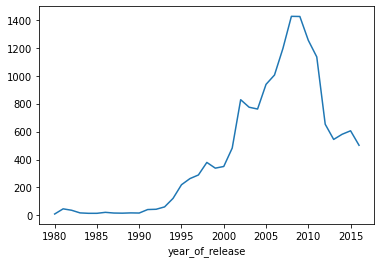

In [15]:
data.groupby('year_of_release')['name'].count().plot();

До 1994 года выпускалось меньше игр, чем после. Данные о годах, за которые выпущено менее 20 игр представляют меньшую важность для анализа.

### Продажи по платформам

In [16]:
#Какие плотформы имеют наибольшие суммарные продажи
data.groupby('platform')['total_sales'].sum().sort_values().tail(10)

platform
3DS      257.81
PSP      289.53
GBA      312.88
PS4      314.14
PS       727.58
DS       802.78
Wii      891.18
PS3      931.34
X360     961.24
PS2     1233.56
Name: total_sales, dtype: float64

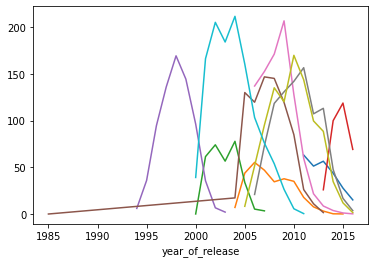

In [17]:
popular_platform = data.groupby('platform')['total_sales'].sum().sort_values().tail(10).index

for platform in popular_platform:
    data[data['platform'] == platform].groupby('year_of_release')['total_sales'].sum().plot();

В среднем игры для платформ продаются в течении 10 лет после появления платформы. Примерно через 5 лет выпускается новая и популярность предыдущих идет на спад. Таким образом, актуальный период составит 4 года.

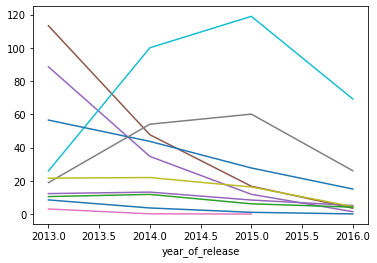

In [18]:
popular_platform = data.groupby('platform')['total_sales'].sum().sort_values().tail(10).index

for platform in data['platform'].unique():
    data[(data['platform'] == platform) & (data['year_of_release'] > 2012)]\
    .groupby('year_of_release')['total_sales'].sum().plot();

In [19]:
data[data['year_of_release'] == 2015].groupby('platform')['total_sales'].sum().sort_values().tail(10)

platform
PSP       0.12
Wii       1.14
PSV       6.25
PC        8.52
X360     11.96
WiiU     16.35
PS3      16.82
3DS      27.78
XOne     60.14
PS4     118.90
Name: total_sales, dtype: float64

На графике видно две платформы, которые в 2014 и 2015 году увеличивают свою популярность. Это XOne и PS4.
На основе наблюдений они будут популярны еще 2 года и являются потенциально прибыльными. Продажи остальных платформ падают.

In [20]:
actual_data = data[data['year_of_release'] > 2012]

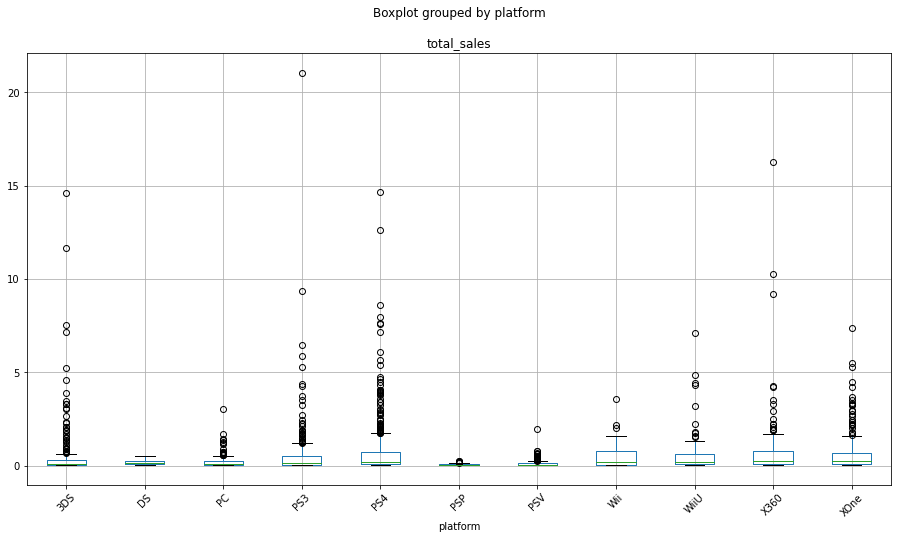

In [21]:
actual_data.boxplot(column='total_sales', by='platform', rot=45, figsize=(15, 8));

У различных платформ схожее среднее значение глобальных продаж, но так же имеется много игр, которые оказались значительно популярнее других для той же платформы. Таким образом, использование только платформы для определения популярности игр не дает точного результата.

### Корреляция между отзывами и продажами

Рассмотрим влияние оценок критиков и пользователей на продажи игр на примере платформы PS4.

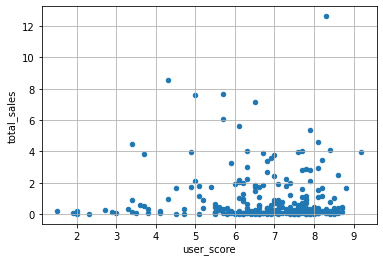

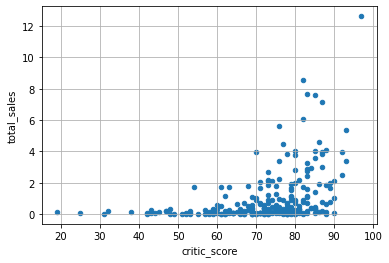

In [23]:
data_ps4 = actual_data[actual_data['platform'] == 'PS4']
data_ps4.plot(y='total_sales', x='user_score', kind='scatter', grid=True);
data_ps4.plot(y='total_sales', x='critic_score', kind='scatter', grid=True);

In [24]:
data_ps4['total_sales'].corr(data_ps4['user_score'])

-0.031957110204556376

In [25]:
data_ps4['total_sales'].corr(data_ps4['critic_score'])

0.406567902061781

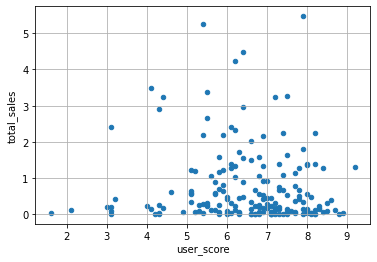

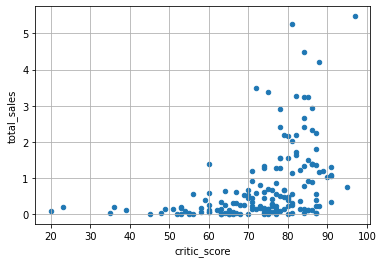

In [26]:
data_xone = actual_data[actual_data['platform'] == 'XOne']
data_xone.plot(y='total_sales', x='user_score', kind='scatter', grid=True);
data_xone.plot(y='total_sales', x='critic_score', kind='scatter', grid=True);

In [27]:
data_xone['total_sales'].corr(data_xone['user_score'])

-0.06892505328279412

In [28]:
data_xone['total_sales'].corr(data_xone['critic_score'])

0.41699832800840175

**Вывод:** суммарные продажи почти не зависят от оценок пользователей, имеется слабая зависимость от оценок критиков. Игры с соценкой критиков ниже 50 имеют небольшие продажи, а игры с высокими оценками могут как быть продаваемыми, так и остаться непопулярными.

Для других платформ ожидается схожая зависимость.

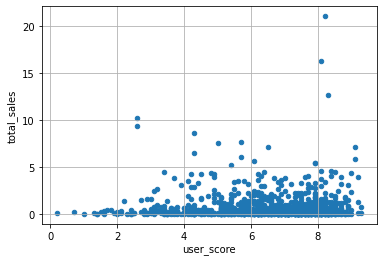

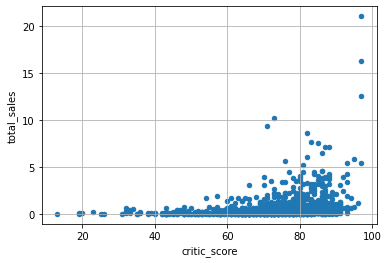

In [29]:
actual_data.plot(y='total_sales', x='user_score', kind='scatter', grid=True);
actual_data.plot(y='total_sales', x='critic_score', kind='scatter', grid=True);

In [30]:
actual_data['total_sales'].corr(data_xone['user_score'])

-0.06892505328279412

In [31]:
actual_data['total_sales'].corr(data_xone['critic_score'])

0.41699832800840175

### Продажи по жанрам

In [32]:
data.pivot_table(index='genre', values=['total_sales'], aggfunc=['sum', 'count', 'mean'])

,sum,count,mean
,total_sales,total_sales,total_sales
genre,,,
Action,1716.52,3307,0.519057
Adventure,233.33,1293,0.180456
Fighting,442.66,837,0.528865
Misc,790.29,1721,0.459204
Platform,825.55,878,0.940262
Puzzle,239.89,569,0.421599
Racing,723.49,1226,0.590122
Role-Playing,931.08,1481,0.628683


In [33]:
actual_data.pivot_table(index='genre', values=['total_sales'], aggfunc=['sum', 'count', 'mean'])

,sum,count,mean
,total_sales,total_sales,total_sales
genre,,,
Action,321.87,766,0.420196
Adventure,23.64,245,0.096490
Fighting,35.31,80,0.441375
Misc,62.82,155,0.405290
Platform,42.63,74,0.576081
Puzzle,3.17,17,0.186471
Racing,39.89,85,0.469294
Role-Playing,145.89,292,0.499623


**Вывод:** больше всего игр выпущено в жанрах Action и Sports, они же обладают наибольшими суммарными продажами. 
Высокими средними показателями продаж для каждой игры обладают игры в жанрах Platform и Shooter. А наменьшими жанры Adventure и Strategy.

Если рассмаатривать актуальный период, то больше всего игр выпущено в жанре Action, он же обладает наибольшими суммарными продажами. Высокими средними показателями продаж для каждой игры обладают игры в жанрах Shooter и Sports. А наменьшими жанры Adventure, Puzzle и Strategy.

## Портрет пользователя каждого региона

### Популярные платформы

In [34]:
na_user = actual_data.groupby('platform')['na_sales'].sum().sort_values().tail().to_frame()
na_user = na_user.merge(data.groupby('platform')['total_sales'].sum(), on='platform', how='left')
na_user['proportion'] = na_user['na_sales'] / na_user['total_sales']

In [35]:
na_user

,na_sales,total_sales,proportion
platform,,,
3DS,38.20,257.81,0.148171
PS3,63.50,931.34,0.068181
X360,81.66,961.24,0.084953
XOne,93.12,159.32,0.584484
PS4,108.74,314.14,0.346151


In [36]:
eu_user = actual_data.groupby('platform')['eu_sales'].sum().sort_values().tail().to_frame()
eu_user = eu_user.merge(data.groupby('platform')['total_sales'].sum(), on='platform', how='left')
eu_user['proportion'] = eu_user['eu_sales'] / eu_user['total_sales']

In [37]:
eu_user

,eu_sales,total_sales,proportion
platform,,,
3DS,30.96,257.81,0.120088
X360,42.52,961.24,0.044235
XOne,51.59,159.32,0.323814
PS3,67.81,931.34,0.072809
PS4,141.09,314.14,0.449131


In [38]:
jp_user = actual_data.groupby('platform')['jp_sales'].sum().sort_values().tail().to_frame()
jp_user = jp_user.merge(data.groupby('platform')['total_sales'].sum(), on='platform', how='left')
jp_user['proportion'] = jp_user['jp_sales'] / jp_user['total_sales']

In [39]:
jp_user

,jp_sales,total_sales,proportion
platform,,,
WiiU,10.88,82.19,0.132376
PS4,15.96,314.14,0.050805
PSV,18.59,53.81,0.345475
PS3,23.35,931.34,0.025071
3DS,67.81,257.81,0.263023


**Вывод:** во всех регионах популяными являются 3DS, PS3 и PS4. В Северной Америке и Европе так же популяны X360 и XOne. А в Японии PSV и WiiU.

### Популярные жанры

In [40]:
na_user = actual_data.groupby('genre')['na_sales'].sum().sort_values().tail().to_frame()
na_user = na_user.merge(data.groupby('genre')['total_sales'].sum(), on='genre', how='left')
na_user['proportion'] = na_user['na_sales'] / na_user['total_sales']

In [41]:
na_user

,na_sales,total_sales,proportion
genre,,,
Misc,27.49,790.29,0.034785
Role-Playing,46.40,931.08,0.049835
Sports,65.27,1309.67,0.049837
Shooter,109.74,1041.36,0.105381
Action,126.05,1716.52,0.073433


In [42]:
eu_user = actual_data.groupby('genre')['eu_sales'].sum().sort_values().tail().to_frame()
eu_user = eu_user.merge(data.groupby('genre')['total_sales'].sum(), on='genre', how='left')
eu_user['proportion'] = eu_user['eu_sales'] / eu_user['total_sales']

In [43]:
eu_user

,eu_sales,total_sales,proportion
genre,,,
Racing,20.19,723.49,0.027906
Role-Playing,36.97,931.08,0.039707
Sports,60.52,1309.67,0.046210
Shooter,87.86,1041.36,0.084370
Action,118.13,1716.52,0.068819


In [44]:
jp_user = actual_data.groupby('genre')['jp_sales'].sum().sort_values().tail().to_frame()
jp_user = jp_user.merge(data.groupby('genre')['total_sales'].sum(), on='genre', how='left')
jp_user['proportion'] = jp_user['jp_sales'] / jp_user['total_sales']

In [45]:
jp_user

,jp_sales,total_sales,proportion
genre,,,
Shooter,6.61,1041.36,0.006347
Fighting,7.65,442.66,0.017282
Misc,9.20,790.29,0.011641
Action,40.49,1716.52,0.023588
Role-Playing,51.04,931.08,0.054818


**Вывод:** популярными жанрами во всех регионах являются Action, Shooter и Role-Playing. В Северное Америке так же популярен жанр Sports. В Европе Racing и Sports. В Японии - Fighting.

### Влияние рейтинга ESRB

In [46]:
na_user = actual_data.groupby('rating')['na_sales'].sum().sort_values().to_frame()
na_user = na_user.merge(data.groupby('rating')['total_sales'].sum(), on='rating', how='left')
na_user['proportion'] = na_user['na_sales'] / na_user['total_sales']

In [47]:
na_user

,na_sales,total_sales,proportion
rating,,,
T,49.79,1473.08,0.033800
E10+,54.24,640.98,0.084620
E,79.05,2407.61,0.032833
no_rating,89.42,2822.10,0.031686
M,165.21,1462.53,0.112962


In [48]:
eu_user = actual_data.groupby('rating')['eu_sales'].sum().sort_values().to_frame()
eu_user = eu_user.merge(data.groupby('rating')['total_sales'].sum(), on='rating', how='left')
eu_user['proportion'] = eu_user['eu_sales'] / eu_user['total_sales']

In [49]:
eu_user

,eu_sales,total_sales,proportion
rating,,,
T,41.95,1473.08,0.028478
E10+,42.69,640.98,0.066601
no_rating,78.91,2822.10,0.027961
E,83.36,2407.61,0.034624
M,145.32,1462.53,0.099362


In [50]:
jp_user = actual_data.groupby('rating')['jp_sales'].sum().sort_values().to_frame()
jp_user = jp_user.merge(data.groupby('rating')['total_sales'].sum(), on='rating', how='left')
jp_user['proportion'] = jp_user['jp_sales'] / jp_user['total_sales']

In [51]:
jp_user

,jp_sales,total_sales,proportion
rating,,,
E10+,5.89,640.98,0.009189
M,14.11,1462.53,0.009648
E,15.14,2407.61,0.006288
T,20.59,1473.08,0.013978
no_rating,85.05,2822.10,0.030137


**Вывод:** в Северной Америке и Европе покупают больше игр с рейтингом E и M, а так же игры не получившие рейтинг. В Японии большую часть продаж занимают игры без рейтинга.

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Проверка гипотезы: средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

```
H_0: Пользовательские рейтинги (user_score) платформы Xbox One = пользовательские рейтинги (user_score) платформы PC`
H_a: Пользовательские рейтинги (user_score) платформы Xbox One ≠ пользовательские рейтинги (user_score) платформы PC`
alpha = 0.05
```

In [52]:
results = st.ttest_ind(
    actual_data[(actual_data['platform'] =='XOne') & (actual_data['user_score'].notnull())]['user_score'], 
    actual_data[(actual_data['platform'] =='PC') & (actual_data['user_score'].notnull())]['user_score'],
    equal_var = False)

alpha = 0.05
print(results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

0.14759594013430463

Не получилось отвергнуть нулевую гипотезу


Пользовательские оценки игр для платформы Xbox One равны оценкам игр для платформы PC.

### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Проверка гипотезы: средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные;

```
H_0: Пользовательские рейтинги (user_score) игр жанра Action = пользовательские рейтинги (user_score) жанра Sports`
H_a: Пользовательские рейтинги (user_score) игр жанра Action ≠ пользовательские рейтинги (user_score) жанра Sports`
alpha = 0.05
```

In [53]:
results = st.ttest_ind(
    actual_data[(actual_data['genre'] =='Action') & (actual_data['user_score'].notnull())]['user_score'], 
    actual_data[(actual_data['genre'] =='Sports') & (actual_data['user_score'].notnull())]['user_score'],
    equal_var = False)

alpha = 0.05
print(results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

1.4460039700704315e-20

Отвергаем нулевую гипотезу


Пользовательские оценки игр жанра Action и жанра Sports различаются.

## Вывод

**Общий вывод:**

Было проведено исследование данных с целью прогнозирования успешности продаж игры и выявления закономерностей определяющих успешность. Входные данные - информация о продажах игр до 2016 года.

Выполнены следующие шаги:
- Устранены пропуски;
- Добавлены новые столбец для исслдеования;
- Проведен исследовательский анализ данных;
- Рассмотрено, сколько времени нужно для появления новой платформы и как долго удерживает популярность существующие;
- Исследовано влияние оценок на продажи игр;
- Изучено распределение игр по жанрам;
- Составлен портрет пользователей для трех регионов;
- Проверены две гипотезы.

**Результаты**

**Вопрос 1. За какой характерный срок появляются новые и исчезают старые платформы?** Примерно 10 лет выпускаются игры для одной платформы, каждые 5 лет повляется хотя бы одна новая. Около 3 лет платформа удерживает популярность.

**Вопрос 2. Как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков?** Было выявлено, что оценки пользователей не влияют на продажи игр, а оценки критиков оказывают слабое влияние.

**Вопрос 3.  Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?** Если рассмаатривать актуальный период, то больше всего игр выпущено в жанре Action, он же обладает наибольшими суммарными продажами. Высокими средними показателями продаж для каждой игры обладают игры в жанрах Shooter и Sports. А наменьшими жанры Adventure, Puzzle и Strategy.

**Портрет пользователей регионов** Во всех регионах популяными являются 3DS, PS3 и PS4. В Северной Америке и Европе так же популяны X360 и XOne. А в Японии PSV и WiiU. 
Популярными жанрами во всех регионах являются Action, Shooter и Role-Playing. В Северное Америке так же популярен жанр Sports. В Европе Racing и Sports. В Японии - Fighting.
В Северной Америке и Европе покупают больше игр с рейтингом E и M, а так же игры не получившие рейтинг. В Японии большую часть продаж занимают игры без рейтинга.

**Гипотезы**
**Гипотеза 1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.** Данная гипотеза была принята, пользовательские оценки игр на платформах Xbox One и PC одиннаковые.

**Гипотеза 2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.** Гипотеза была принята, пользовательские оценки игр в жанрах Action и Sports разные.

**Рекомендации для рекламной компании на 2017 год** уделить большее внимае играм для платформ 3DS, XOne и PS4. В жанрах Action, Shooter и Role-Playing. С рейтингом E и M. Высокие оценки критиков так же являются поводом обратить внимание на игру.